In [25]:
import multiprocess as mp

from glob import glob
import re
import pandas as pd
import numpy as np
import os

from PIL import Image
import cv2

# Cleaning of wine label data set

Read in sizes of all wine labels to begin analysis.

In [26]:
snooth_images = glob('../images/snooth_dot_com_*.*')
wine_dot_com_images = glob('../images/wine_dot_com_*.*')

int_sorter = lambda x: int(re.search(r"""_([0-9]+)\.""", x).group(1))
snooth_images = sorted(snooth_images, key=int_sorter)
wine_dot_com_images = sorted(wine_dot_com_images, key=int_sorter)

In [27]:
def get_sizes(file_list):
    
    file_df = list()

    for fil in file_list:
        try:
            with Image.open(fil) as im:
                width, height = im.size        
        except:
            width = np.NaN
            height = np.NaN

        file_ser = pd.Series({'image_name':fil, 'width':width, 'height':height})
        
        file_df.append(file_ser)
        
    return file_df

In [28]:
file_list = snooth_images
file_list.extend(wine_dot_com_images)

In [30]:
nthreads = 48
pool = mp.Pool(processes=nthreads)
size_list = pool.map(get_sizes, np.array_split(file_list, nthreads))
pool.close()

In [31]:
image_size_df = pd.concat(sum(size_list,[]), axis=1).T

In [32]:
image_size_df['height'] = image_size_df.height.astype(int)
image_size_df['width'] = image_size_df.width.astype(int)
image_size_df['area'] = image_size_df.height * image_size_df.width

In [38]:
image_size_df.shape

(57927, 4)

In [39]:
def extract_basename(x):
    return os.path.splitext(os.path.basename(x))[0]

image_size_df['basename'] = image_size_df.image_name.apply(extract_basename)

In [40]:
image_size_df.area.min(), image_size_df.area.max()

(1, 2929184)

# Visualize label sizes
Visualize the size of the images in a histogram.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2099876910>]], dtype=object)

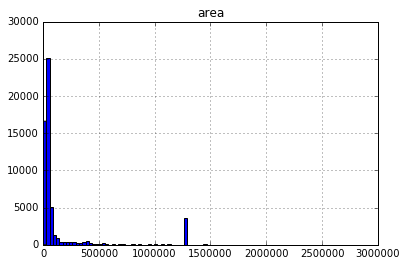

In [46]:
image_size_df.hist('area', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f20982650d0>]], dtype=object)

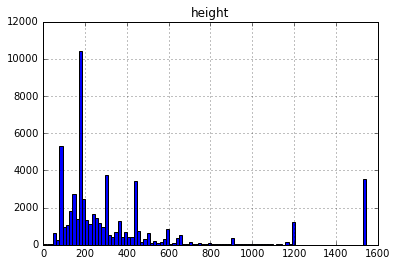

In [47]:
image_size_df.hist('height', bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2096ee3910>]], dtype=object)

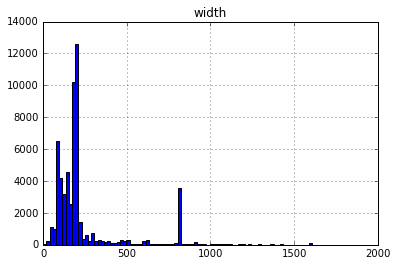

In [48]:
image_size_df.hist('width', bins=100)

# Data cleaning notes

Specifically, there are many labels such at the one below that are "placeholders". There are other labels that are additionally just very small.

In [49]:
img = Image.open('../images/snooth_dot_com_47220.png')
img.size

(87, 87)

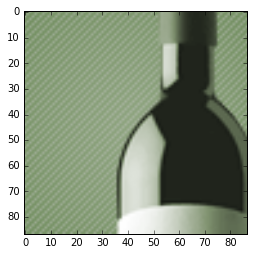

In [50]:
plt.imshow(img)

It also appears that some of the very large images will need to be removed. I believe these are only in the Wine.com data set.

In [51]:
image_size_df.loc[image_size_df.area == image_size_df.area.max()]

,height,image_name,width,area,basename
57840,1532,../images/wine_dot_com_8433.jpg,1912,2929184,wine_dot_com_8433
57845,1532,../images/wine_dot_com_8438.jpg,1912,2929184,wine_dot_com_8438
57854,1532,../images/wine_dot_com_8447.jpg,1912,2929184,wine_dot_com_8447
57895,1532,../images/wine_dot_com_8488.jpg,1912,2929184,wine_dot_com_8488
57900,1532,../images/wine_dot_com_8493.jpg,1912,2929184,wine_dot_com_8493
57903,1532,../images/wine_dot_com_8496.jpg,1912,2929184,wine_dot_com_8496
57904,1532,../images/wine_dot_com_8497.jpg,1912,2929184,wine_dot_com_8497
57923,1532,../images/wine_dot_com_8516.jpg,1912,2929184,wine_dot_com_8516


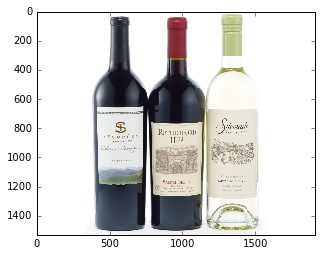

In [52]:
plt.imshow(Image.open('../images/wine_dot_com_8516.jpg'))

# Data for preliminary analysis
Save the filenames of the high(-ish) resolution images to use for preliminary analysis. 

In [53]:
mask = (image_size_df.area>1.0e6)&(image_size_df.area<1.5e6)
mask.sum()

4117

In [54]:
image_size_df.loc[mask].to_pickle('../pkl/20_wine_label_analysis_large_labels.pkl')

# Cleaning of data
Remove small images

In [55]:
mask = image_size_df.area>10000
image_size_df_out = image_size_df[mask]
image_size_df_out.shape

(51372, 5)

In [59]:
mask = np.invert((image_size_df.area>1.5e6)&(image_size_df['basename'].str.contains('wine_dot_com')))
image_size_df_out = image_size_df_out[mask]
image_size_df_out.shape

/home/ubuntu/miniconda/envs/scienv2/lib/python2.7/site-packages/ipykernel/__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


(51364, 5)

In [60]:
image_size_df_out.to_pickle('../pkl/20_wine_label_analysis_all_labels.pkl')

## Average color histogram
Histogram of nine image regions

In [211]:
height, width = image.shape[:2]
nrows = 3
ncols = 3
w = int(width/ncols)
h = int(height/nrows)

segments = list()
for r in range(nrows):
    for c in range(ncols):
        x_beg = c*w
        y_beg = r*h
        
        if c != (ncols-1):
            x_end = (c+1)*w
        else:
            x_end = width+1
            
        if r != (nrows-1):
            y_end = (r+1)*h
        else:
            y_end = height+1
            
        segments.append((x_beg, x_end, y_beg, y_end))
        
segments

[(0, 99, 0, 138),
 (99, 198, 0, 138),
 (198, 298, 0, 138),
 (0, 99, 138, 276),
 (99, 198, 138, 276),
 (198, 298, 138, 276),
 (0, 99, 276, 416),
 (99, 198, 276, 416),
 (198, 298, 276, 416)]

In [212]:
bins = (4, 6, 3)
# bins = (64, 64, 64)

image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
features = []

# loop over the segments
for (x_beg, x_end, y_beg, y_end) in segments:
    
    # construct a mask for each part of the image
    squareMask = np.zeros(image.shape[:2], dtype='uint8')
    cv2.rectangle(squareMask, (x_beg, y_beg), (x_end, y_end), 255, -1)
    
    hist = cv2.calcHist([image], [0, 1, 2], squareMask, bins, [0, 180, 0, 256, 0, 256])
    hist = cv2.normalize(hist).flatten()
    
    features.extend(hist)

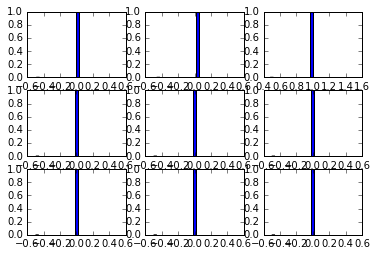

In [213]:
f, axList = plt.subplots(nrows=3, ncols=3)

for his,ax in zip(hist, axList.flatten()):
    ax.hist(his, bins=25)